In [123]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later

import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import load_dir

In [214]:
def shift_correct(input_pos,idx):
    output_pos = np.insert(input_pos,0,np.linspace(0,0,idx))
    return output_pos

def gaussian(data_x,params=list):
    norm = (1/((1/2*params[2])*np.sqrt(np.pi * 2)))
    return params[0] * norm * np.exp(-(np.subtract(data_x,params[1])**2/(2*params[2]**2)))+params[3]

def gaussian_cdf(data_x,params=list):
    # for normalization a 1/sigma could be needed
    return params[0]*0.5*(1+scipy.special.erf((data_x-params[1])/(np.sqrt(2)*params[2])))+params[3]

def linear(data_x,params=list):
    return params[0]*data_x+params[1]

def chisquare_1d(function, functionparams, data_x, data_y,data_y_error):
    chisquarevalue=np.sum(np.power(np.divide(np.subtract(function(data_x,functionparams),data_y),data_y_error),2))
    ndf = len(data_y)-len(functionparams)
    #print(ndf)
    return (chisquarevalue, ndf)

def chisquare_linear(a,b):
    return chisquare_1d(function=linear,functionparams=[a,b],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

def chisquare_gaussian(area,mean,sigma,constant):
    return chisquare_1d(function=gaussian,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

def chisquare_gaussian_cdf(amp,mean,sigma,constant):
    return chisquare_1d(function=gaussian_cdf,functionparams=[amp,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

------------------------------------------------------------------
| FCN = 1.815                   |      Ncalls=35 (35 total)      |
| EDM = 1.22E-11 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
0.019834000085488412 -0.0015000315197539749


/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
  # This is added back by InteractiveShellApp.init_path()


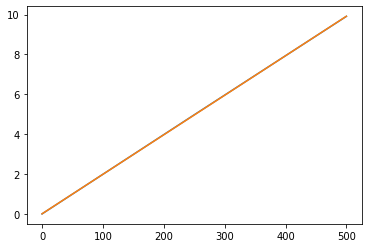

In [134]:
pos_list=np.asarray([-0.007,4.968,9.91])
y_err=np.asarray([0.01,0.01,0.01])
val = np.asarray([0,250,500])
data_x=val
data_y=pos_list
data_y_error=y_err
m2=Minuit(chisquare_linear, 
     a = 100,
     b=0,
     errordef = 1,
     print_level=1)

m2.migrad()

print(m2.values["a"],m2.values["b"])
plt.plot(val,pos_list)
plt.plot(val,m2.values["a"]*val+m2.values["b"])

In [126]:
# calibration of the voltage - position conversion

def voltage_to_position(voltage,slope=0.019834000085488412,offset=-0.0015000315197539749,redo=False):
    if(redo==True):
        pos_list=np.asarray([-0.007,4.968,9.91])
        y_err=np.asarray([0.01,0.01,0.01])
        val = np.asarray([0,250,500])
        data_x=val
        data_y=pos_list
        data_y_error=y_err
        m2=Minuit(chisquare_linear, 
             a = 100,
             b=0,
             errordef = 1,
             print_level=1)
        m2.migrad()
        print(m2.values["a"],m2.values["b"])
        plt.plot(val,pos_list,marker="*")
        plt.plot(val,m2.values["a"]*val+m2.values["b"])
        slope = m2.values["a"]
        offset = m2.values["b"]
    position=(voltage-offset)/slope
    return position

In [127]:
# load the data
Day = "12"
Month = "08"
Year = "2019"
BeadNumber = 1
#RunNumber = 144
folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day +"/Bead"+str(BeadNumber)+"/Shaking/"
files = load_dir(folder, file_prefix = 'BeamProfiling', max_file=500)
pos_x = files[0].cant_pos[0]
pos_y = files[0].cant_pos[1]
pos_z = files[0].cant_pos[2]
quad_sum = files[0].quad_sum


10  files in folder
10  files loaded


In [128]:
len(files)

10

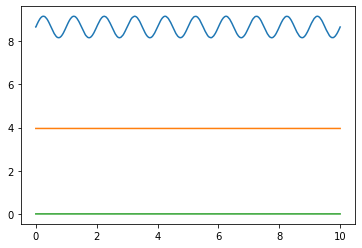

In [129]:
x = np.arange(0,len(pos_x)/5000,1/5000)
plt.plot(x,pos_x)
plt.plot(x,pos_y)
plt.plot(x,pos_z)

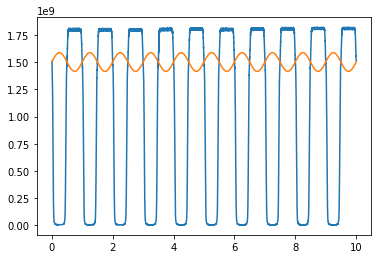

In [130]:
plt.plot(x,quad_sum)
plt.plot(x,quad_sum[0]/(pos_x[0])*pos_x)


In [224]:
def get_average_mean_position(file_list):
    position_list = []
    
    def chisquare_gaussian_cdf(amp,mean,sigma,constant):
        return chisquare_1d(function=gaussian_cdf,functionparams=[amp,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
    
    for i in np.arange(0,len(file_list),1):#len(file_list),1):
        print(i)
        data_x = file_list[i].cant_pos[0] # give x data
        data_y = file_list[i].quad_sum# give y data 
        data_y_error = np.sqrt(np.abs(data_y)) # give y uncertainty  
        m=Minuit(chisquare_gaussian_cdf, 
         amp = -1.75e9, # set start parameter
         #limit_area= (limit_lower,limit_upper) # if you want to limit things
         #limit_amp =  # you can also fix it
         mean = 7.9,
         #fix_mean = "True",
         #limit_mean = (3500,4500),
         sigma = 0.5e-1,
         constant = 1.75e9,
         #fix_constant="True",
         errordef = 1,
         print_level=0,pedantic=False)
         #print('Now proceed with the fit.')
        m.migrad(ncall=500000)
        position_list.append(voltage_to_position(m.values["mean"]))
        plt.plot(voltage_to_position(data_x),data_y)
        plt.plot(voltage_to_position(data_x),gaussian_cdf(data_x,params=[m.values["amp"],m.values["mean"],m.values["sigma"],m.values["constant"]]))
        plt.show() 
    return position_list,np.mean(position_list),np.std(position_list)


0


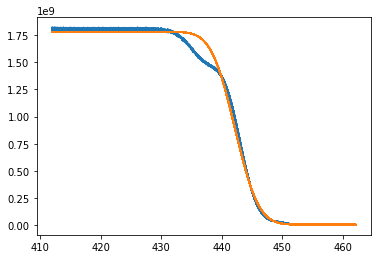

1


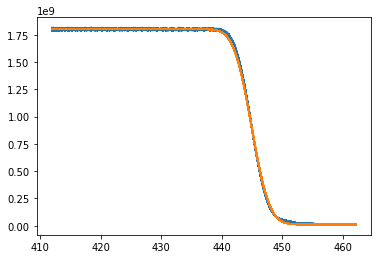

2


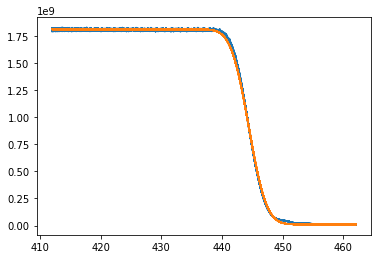

3


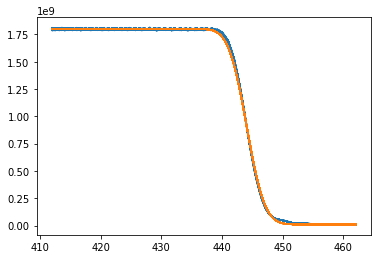

4


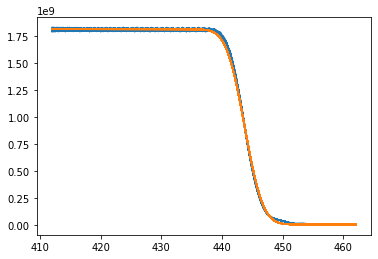

5


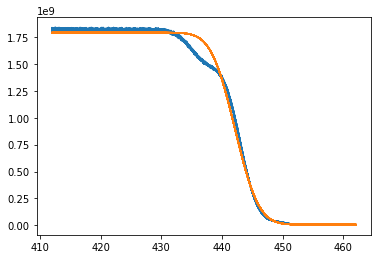

6


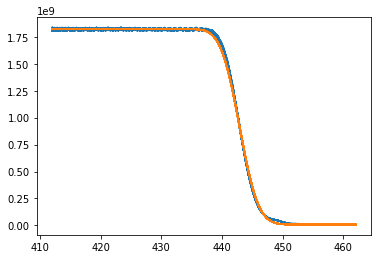

7


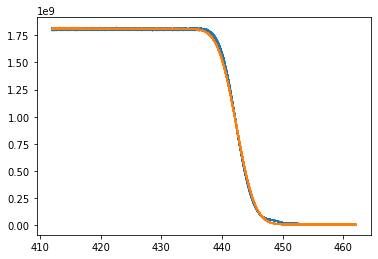

8


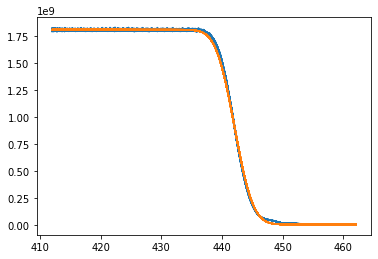

9


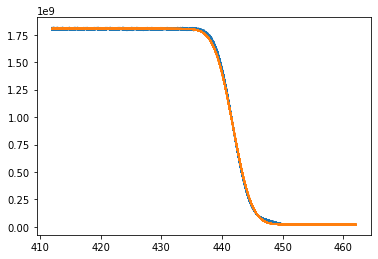

([442.1689910698251,
  444.9108423518599,
  444.4361443010393,
  444.0916813371519,
  443.7619047754748,
  442.1422245557257,
  442.90862328753434,
  442.4165502426173,
  442.07970735508013,
  441.82306272200753],
 443.0739731998316,
 1.0695145356345692)

In [225]:
get_average_mean_position(files)

In [ ]:
# to do
# chi2 criterion to use or not use a fit
# linear fit to all of them? 
# proper uncertainties